In [26]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from ingest.ohlcv import get_connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [27]:
# ensure correct conection with db
with get_connection() as conn:
    cur = conn.execute("PRAGMA database_list;")
    print(cur.fetchall())


[(0, 'main', 'C:\\Users\\alexd\\Documents\\TFG_inversion_bolsa\\data\\ibex35.db')]


In [28]:
with get_connection() as conn:
    df = pd.read_sql("SELECT * FROM ohlcv", conn)

df.shape

df = df[df["ticker"] == "BBVA.MC"]
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.asfreq("B")
df["close"] = df["close"].ffill()
df.head(1)

,ticker,open,high,low,close,volume
date,,,,,,
2021-01-05,BBVA.MC,4.04,4.093,4.022,4.074,10364379.0


ADF Statistic: 2.111496645035932
p-value: 0.9988014146577279
ADF Statistic after differencing: 2.111496645035932
p-value after differencing: 0.9988014146577279
Interpretation: The series is Non-Stationary.
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1308
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 509.189
Date:                Fri, 09 Jan 2026   AIC                          -1010.378
Time:                        19:52:03   BIC                           -989.673
Sample:                    01-06-2021   HQIC                         -1002.611
                         - 01-09-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons

c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


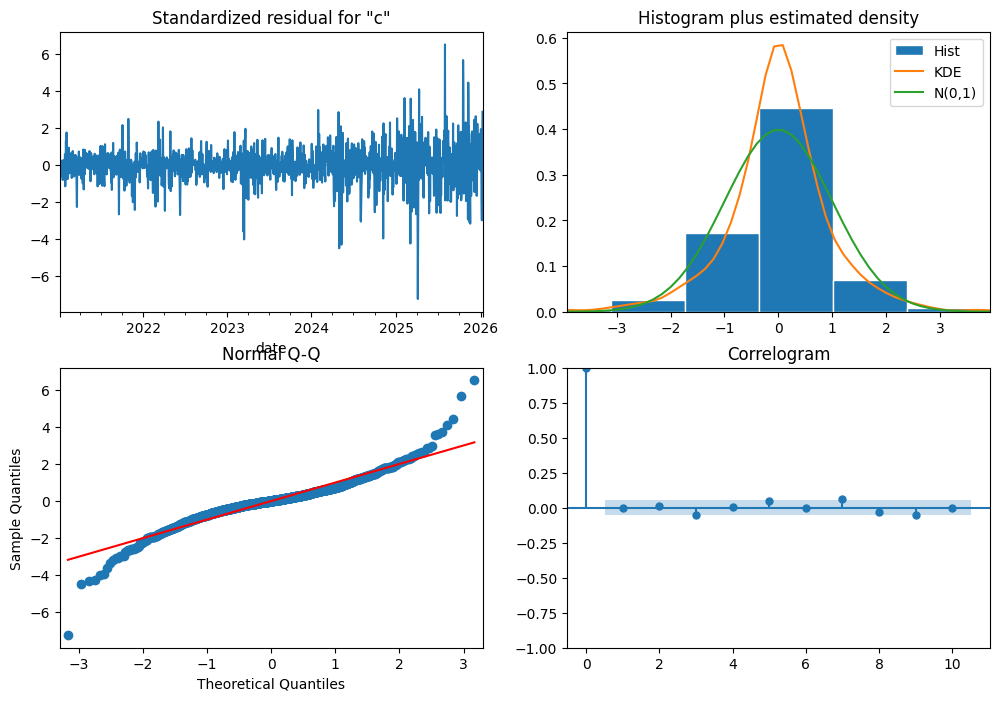

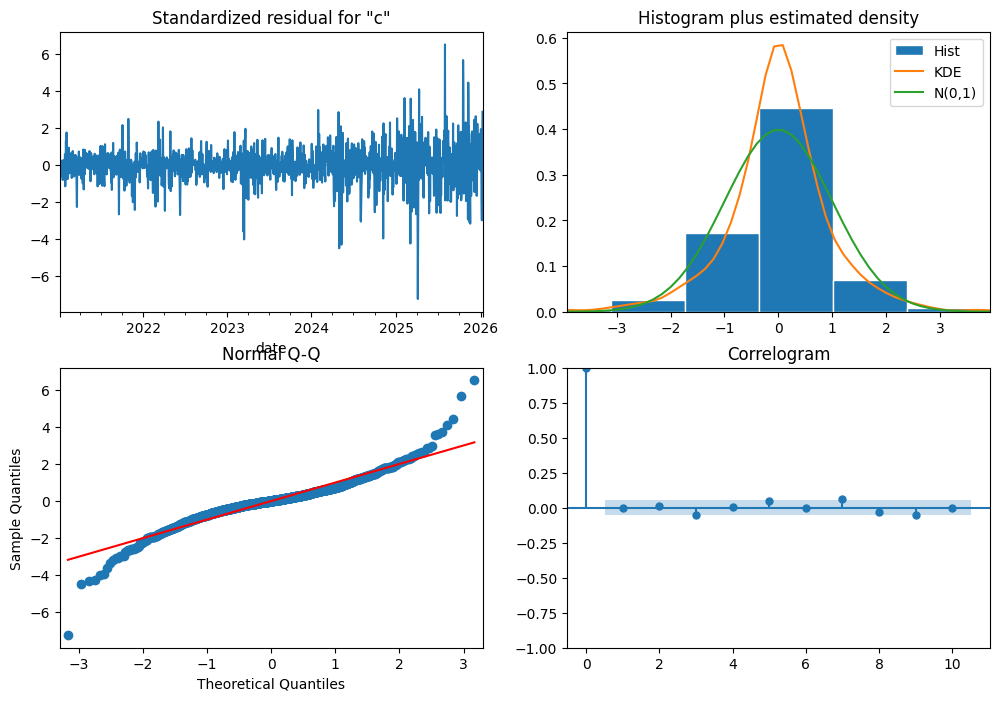

In [29]:
close = df["close"]
test = adfuller(close)
print(f"ADF Statistic: {test[0]}")
print(f"p-value: {test[1]}")

if test[1] > 0.05:
    close = close.diff().dropna()
    result = adfuller(close)
    stationarity_interpretation = (
        "Stationary" if test[1] < 0.05 else "Non-Stationary"
    )

print(f"ADF Statistic after differencing: {test[0]}")
print(f"p-value after differencing: {test[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

p = 1
q= 1
#model_prices = ARIMA(close, order=(p,1,q))  # if modeling prices
model_prices = ARIMA(close, order=(p,0,q))   # 0 as we diff'd earlier
results_p = model_prices.fit()
print(results_p.summary())
results_p.plot_diagnostics(figsize=(12,8))
# check convergence ~mlretreval

2026-01-12    0.019288
2026-01-13    0.012574
2026-01-14    0.012525
2026-01-15    0.012525
2026-01-16    0.012525
2026-01-19    0.012525
2026-01-20    0.012525
2026-01-21    0.012525
2026-01-22    0.012525
2026-01-23    0.012525
Freq: B, Name: predicted_mean, dtype: float64
<bound method PredictionResults.conf_int of <statsmodels.tsa.statespace.mlemodel.PredictionResults object at 0x000002068A57DBA0>>


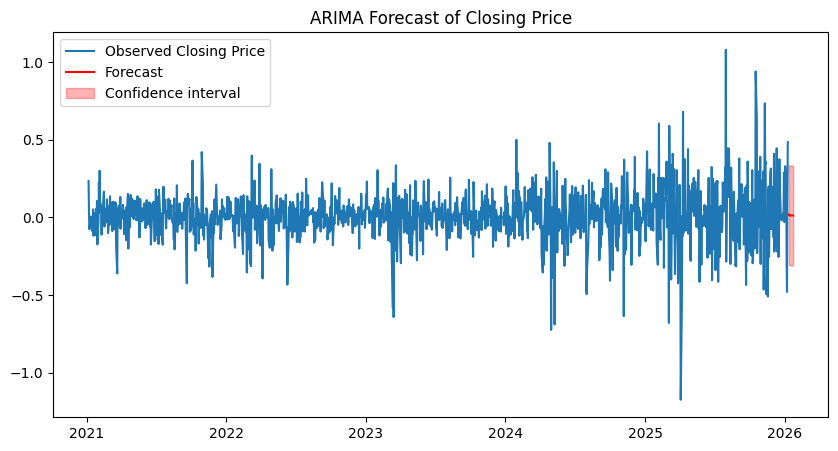

In [ ]:
forecast_p = results_p.get_forecast(steps=10)
print(forecast_p.predicted_mean)
print(forecast_p.conf_int())
plt.figure(figsize=(10,5))

plt.plot(close, label="Observed Closing Price")
plt.plot(forecast_p.predicted_mean, label="Forecast", color="red")
plt.fill_between(
    forecast_p.conf_int().index,
    forecast_p.conf_int().iloc[:, 0],
    forecast_p.conf_int().iloc[:, 1],
    color="red",
    alpha=0.3,
    label="Confidence interval"
)
plt.legend()
plt.title("ARIMA Forecast of Closing Price")
plt.show()

ADF Statistic after differencing: -21.86984925171074
p-value after differencing: 0.0
Interpretation: The series is Stationary.


c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1308
Model:                 ARIMA(1, 0, 1)   Log Likelihood                3299.430
Date:                Fri, 09 Jan 2026   AIC                          -6590.860
Time:                        19:52:04   BIC                          -6570.155
Sample:                    01-06-2021   HQIC                         -6583.094
                         - 01-09-2026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.179      0.029       0.000       0.002
ar.L1          0.0072      1.466      0.005      0.996      -2.866       2.880
ma.L1          0.0072      1.462      0.005      0.9

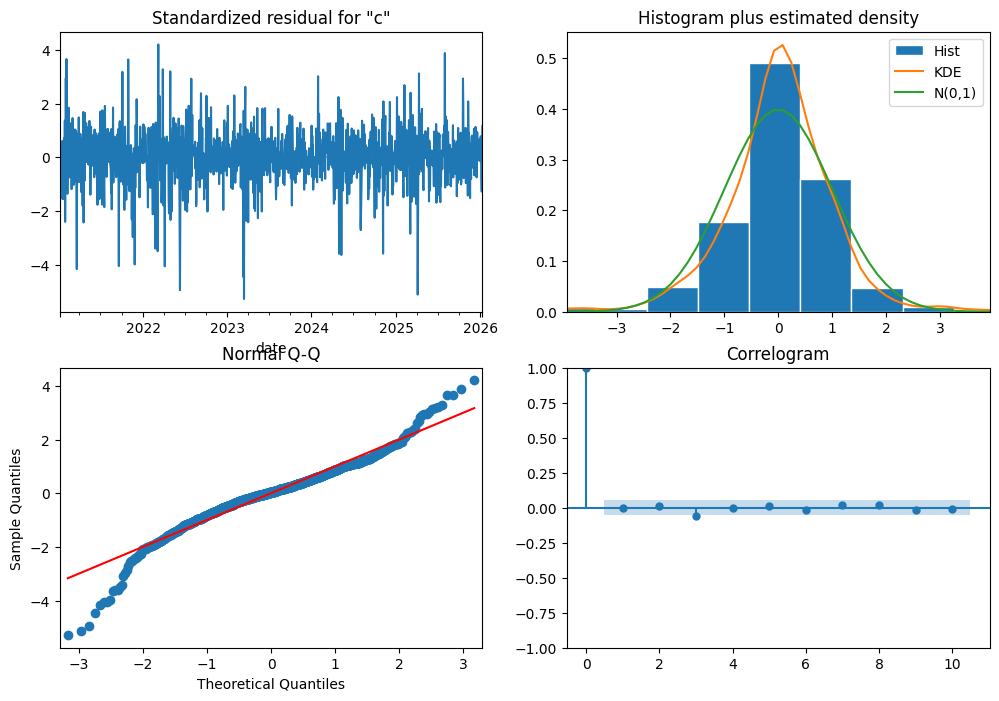

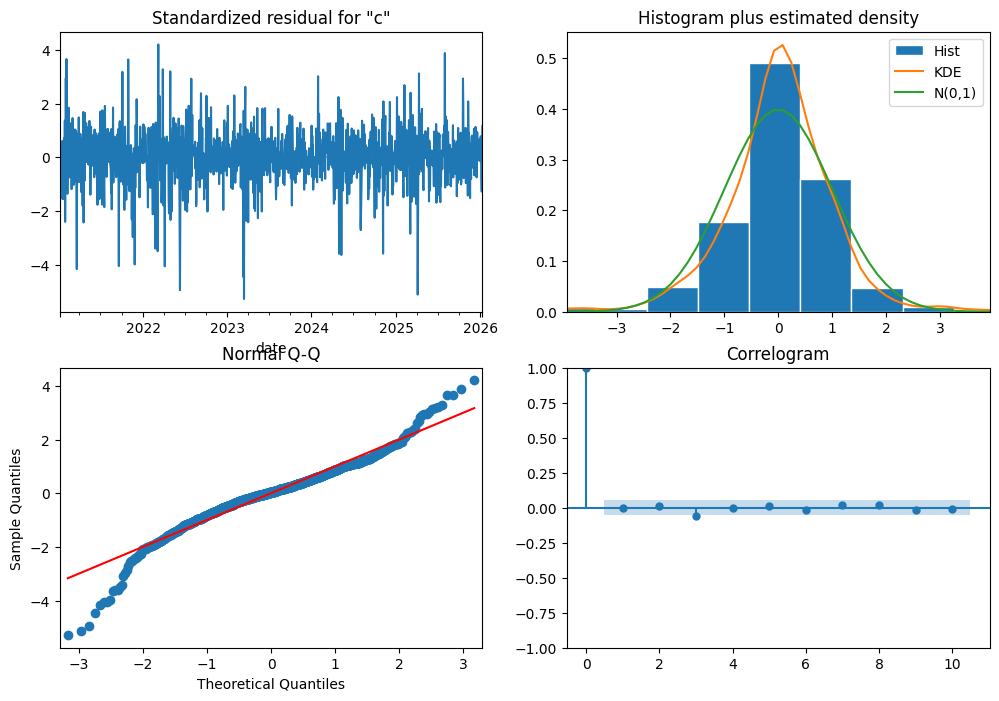

In [31]:
prices = df["close"]
log_returns = np.log(prices).diff().dropna()
result = adfuller(log_returns)   # usually stationary

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
stationarity_interpretation = (
        "Stationary" if result[1] < 0.05 else "Non-Stationary"
    )
print(f"Interpretation: The series is {stationarity_interpretation}.")

p = 1
q = 1
model_returns = ARIMA(log_returns, order=(p,0,q)) # if modeling returns
results_r = model_returns.fit()
print(results_r.summary())
results_r.plot_diagnostics(figsize=(12,8))

2026-01-12    0.001557
2026-01-13    0.001232
2026-01-14    0.001229
2026-01-15    0.001229
2026-01-16    0.001229
2026-01-19    0.001229
2026-01-20    0.001229
2026-01-21    0.001229
2026-01-22    0.001229
2026-01-23    0.001229
Freq: B, Name: predicted_mean, dtype: float64
            lower close  upper close
2026-01-12    -0.036496     0.039610
2026-01-13    -0.036826     0.039289
2026-01-14    -0.036828     0.039287
2026-01-15    -0.036828     0.039287
2026-01-16    -0.036828     0.039287
2026-01-19    -0.036828     0.039287
2026-01-20    -0.036828     0.039287
2026-01-21    -0.036828     0.039287
2026-01-22    -0.036828     0.039287
2026-01-23    -0.036828     0.039287


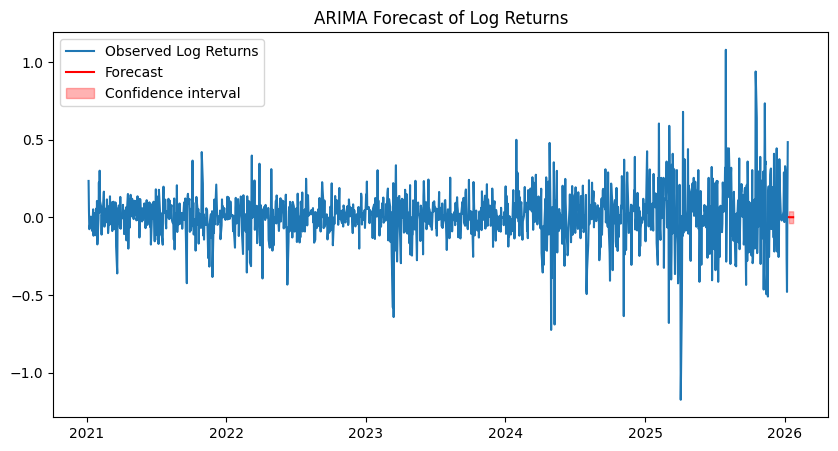

In [33]:
forecast_r = results_r.get_forecast(steps=10)
print(forecast_r.predicted_mean)
print(forecast_r.conf_int())
plt.figure(figsize=(10,5))

plt.plot(close, label="Observed Log Returns")
plt.plot(forecast_r.predicted_mean, label="Forecast", color="red")
plt.fill_between(
    forecast_r.conf_int().index,
    forecast_r.conf_int().iloc[:, 0],
    forecast_r.conf_int().iloc[:, 1],
    color="red",
    alpha=0.3,
    label="Confidence interval"
)
plt.legend()
plt.title("ARIMA Forecast of Log Returns")
plt.show()